In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import milopy  
import milopy.core as milo
from community import community_louvain
import networkx as nx

In [40]:
###def remove_recompute(adata):
   # del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
   # sc.tl.pca(adata, svd_solver='auto')
   # sc.pp.neighbors(adata)  # using with default parameters
   # sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
   # return adata


def remove_recompute(adata):
    # Check if 'X_umap' is present in adata.obsm_keys()
    if 'X_umap' in adata.obsm_keys():
        del adata.obsm['X_umap']
    # Check if 'X_pca' is present in adata.obsm_keys()
    if 'X_pca' in adata.obsm_keys():
        del adata.obsm['X_pca']
    # Check if 'X_diffmap' is present in adata.obsm_keys()
    if 'X_diffmap' in adata.obsm_keys():
        del adata.obsm['X_diffmap']
    # Check if 'connectivities' and 'distances' are present in adata.obsp_keys()
    del adata.obsp['connectivities']
    del adata.obsp['distances']
    # Check if 'diffmap_evals' is present in adata.uns_keys()
    if 'diffmap_evals' in adata.uns_keys():
        del adata.uns['diffmap_evals']
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.diffmap(adata)
    return adata



In [3]:
def write_deres(excel_path, adata, group, de_key):
    # writing results to excel file
    res_cat = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']

    writer = pd.ExcelWriter(excel_path, engine='xlsxwriter')

    for g in group:
        d = {res_cat[0]: adata.uns[de_key][res_cat[0]][str(g)].tolist(),
             res_cat[1]: adata.uns[de_key][res_cat[1]][str(g)].tolist(),
             res_cat[2]: adata.uns[de_key][res_cat[2]][str(g)].tolist(),
             res_cat[3]: adata.uns[de_key][res_cat[3]][str(g)].tolist(),
             res_cat[4]: adata.uns[de_key][res_cat[4]][str(g)].tolist()
             }
        df = pd.DataFrame(data=d)
        df.to_excel(writer, sheet_name=str(g))

    writer.save()

In [4]:
def plot_genes_bootstrap(adata, cc_geneset, cat_order, meta_slot, bar_colors, y_max):
    for gene_name in cc_geneset:
        dat = np.array(adata[:, gene_name].X.todense()).flatten()
        dat_stat = np.zeros((len(np.unique(adata.obs[meta_slot])), 3))
        dat_stat2 = np.zeros((len(np.unique(adata.obs[meta_slot])), 3))
        b = 0

        for g in cat_order:
            i = np.where(adata.obs[meta_slot] == g)[0]
            ci_info = bs.bootstrap(dat[i], stat_func=bs_stats.mean)
            dat_stat[b, 0] = ci_info.value
            dat_stat2[b, 0] = ci_info.value
            dat_stat[b, 1] = dat_stat[b, 0] - ci_info.lower_bound
            dat_stat2[b, 1] = ci_info.lower_bound
            dat_stat[b, 2] = ci_info.upper_bound - dat_stat[b, 0]
            dat_stat2[b, 2] = ci_info.upper_bound
            b = b + 1

        # plotting results as bar graphs
        fig, ax = plt.subplots(figsize=(4, 5))
        bar_ind = cat_order
        barlist = ax.bar(bar_ind, dat_stat[:, 0], yerr=[dat_stat[:, 1], dat_stat[:, 2]], align='center', ecolor='black',
                         capsize=10, color=bar_colors)
        plt.title(gene_name)
        ax.set_ylabel('ln[mRNA counts + 1]')
        ax.set_xticks(np.arange(len(bar_ind)))
        ax.set_xticklabels(bar_ind, rotation=75)
        plt.ylim([0, y_max])
        # plt.tight_layout()

        return dat_stat2

In [5]:
import itertools
from distinctipy import distinctipy

In [6]:
def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash'][z])
            if adata.obs['sample'][z] == 'BD1':
                rep[z] = rep_dict[z_arg]
            else:
                rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep


def build_samplerep(adata, sample_slot, replicate_slot):
    sample_rep = [None] * adata.shape[0]
    for r in np.arange(adata.shape[0]):
        sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
    return sample_rep


def group_nhoods(adata, min_connect, max_difflfc):
    adj_nhood = np.zeros((adata.obsm['nhoods'].shape[1], adata.obsm['nhoods'].shape[1]))

    # only considering single cells belonging to more than one
    overlap_ind = np.where(np.sum(adata.obsm['nhoods'], axis=1) > 1)[0]
    for g in overlap_ind:
        nhood_ind = np.where(adata.obsm['nhoods'][g, :].todense() == 1)[1]
        ij = list(itertools.permutations(nhood_ind, 2))
        for q in ij:
            adj_nhood[q] = adj_nhood[q] + 1

    # still need to filter adj matrix entries to zero by connections (< 3) and LFC match (diff > 0.25?)
    nonzero_ind = np.where(adj_nhood > 0)
    logFC = adata.uns['nhood_adata'].obs['logFC']
    for f in np.arange(len(nonzero_ind[0])):
        if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:
            adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] = 0

    return adj_nhood


def plot_nhood_clusters(adata, cluster_labels, title, alpha=0.1, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan

    # plotting order
    ordered = nhood_adata.obs.sort_values('SpatialFDR', na_position='last').index[::-1]
    nhood_adata = nhood_adata[ordered]

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def plot_durable_clusters(adata, cluster_labels, title, alpha=0.1, beta=0.5, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] < alpha, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] > beta, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < -beta, "graph_color"] = np.nan

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def get_sc_louvain(adata, cluster_slot='louvain'):
    louvain_onehot = np.zeros((adata.uns['nhood_adata'].obs[cluster_slot].shape[0], (np.unique(adata.uns['nhood_adata'].obs[cluster_slot])[-2] + 1).astype('int')))
    for c in adata.uns['nhood_adata'].obs[cluster_slot].index:
        if adata.uns['nhood_adata'].obs[cluster_slot][c] < float('inf'):
            louvain_onehot[int(c), adata.uns['nhood_adata'].obs[cluster_slot][c].astype('int')] = 1

    # get single-cell louvain neighborhood cluster labels
    sc_onehot = adata.obsm['nhoods']*louvain_onehot
    sc_louvain = np.zeros(sc_onehot.shape[0])
    for t in np.arange(sc_onehot.shape[0]):
        if np.sum(sc_onehot[t, :]) == 0:
            sc_louvain[t] = -1
        else:
            sc_louvain[t] = np.argmax(sc_onehot[t, :])

    return sc_louvain.astype('int')


In [7]:
sc.set_figure_params(figsize=(4, 4), fontsize=20)
celltype_dict = {'Basophil': sns.color_palette('tab20', 20)[0],
                 'CCR7+ DC': sns.color_palette('tab20', 20)[2],
                 'CD4+ T cell': sns.color_palette('tab20', 20)[4],
                 'CD8+ T cell': sns.color_palette('tab20', 20)[6],
                 'Fibroblast': sns.color_palette('tab20', 20)[8],
                 'Fibroblast 2': sns.color_palette('tab20', 20)[9],
                 'Macrophage': sns.color_palette('tab20', 20)[10],
                 'Macrophage 2': sns.color_palette('tab20', 20)[11],
                 'Macrophage 3': sns.color_palette('tab20', 20)[13],
                 'Cd3+ Macrophage': sns.color_palette('tab20', 20)[17],
                 'Chil3+ Mac': 'xkcd:grey',
                 'Cx3cr1+ Mac': sns.color_palette('tab20', 20)[19],
                 'Mrc1+ Macrophage': sns.color_palette('tab20b', 20)[0],
                 'cDC2': sns.color_palette('tab20b', 20)[4],
                 'mt-Macrophage': sns.color_palette('tab20', 20)[14],
                 'NK cell': sns.color_palette('tab20', 20)[12],
                 'Neutrophil': sns.color_palette('tab20', 20)[16],
                 'Poorly classified': 'xkcd:light grey',
                 'Mixed': 'xkcd:light grey',
                 'Treg': sns.color_palette('tab20', 20)[1],
                 'Tumor cell': sns.color_palette('tab20', 20)[3],
                 'XCR1+ DC': sns.color_palette('tab20', 20)[5]}

sample_dict = {'Ctrl d8': sns.husl_palette(5)[0],
               'CPI hi d8': sns.husl_palette(5)[1], 'CPI lo d8': sns.husl_palette(5)[2],
               'CD40ag d8': sns.husl_palette(5)[3], 'TTx d8': sns.husl_palette(5)[4]}


In [41]:
adata_d8 = sc.read('/Users/anasuyadighe/Downloads/cpi_cd40_d8_refined.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [42]:
type_annot = adata_d8.obs['nn_80'].values.tolist()
for i in np.where(adata_d8.obs['nn_refined'] == 'cDC2')[0]:
    type_annot[i] = 'cDC2'

adata_d8.obs['celltype'] = type_annot

In [39]:
adata_d8.obsm_keys()

['X_diffmap', 'X_pca', 'X_umap', 'hash', 'protein']

In [33]:
adata_d8

AnnData object with n_obs × n_vars = 8655 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes', 'sample', 'sample_cond', 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_

In [43]:
adata_d8 = adata_d8[np.where(np.sum(adata_d8.obsm['hash'], axis=1) > 0)]


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plottin

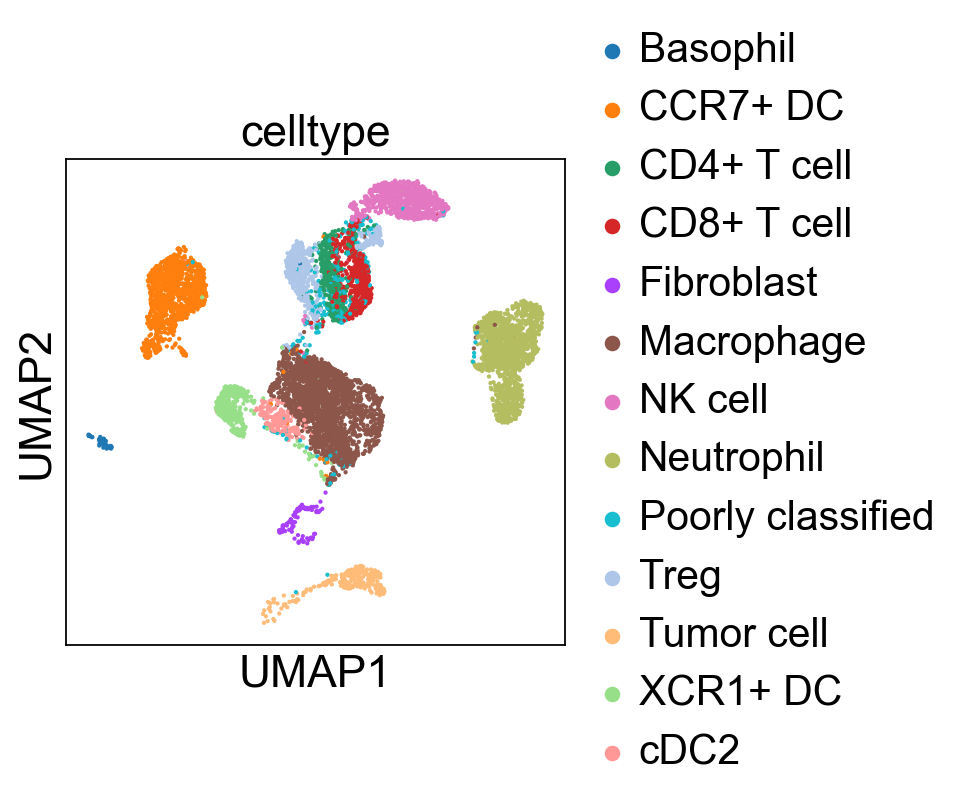

In [44]:
sc.pl.umap(adata_d8, color = 'celltype')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/si

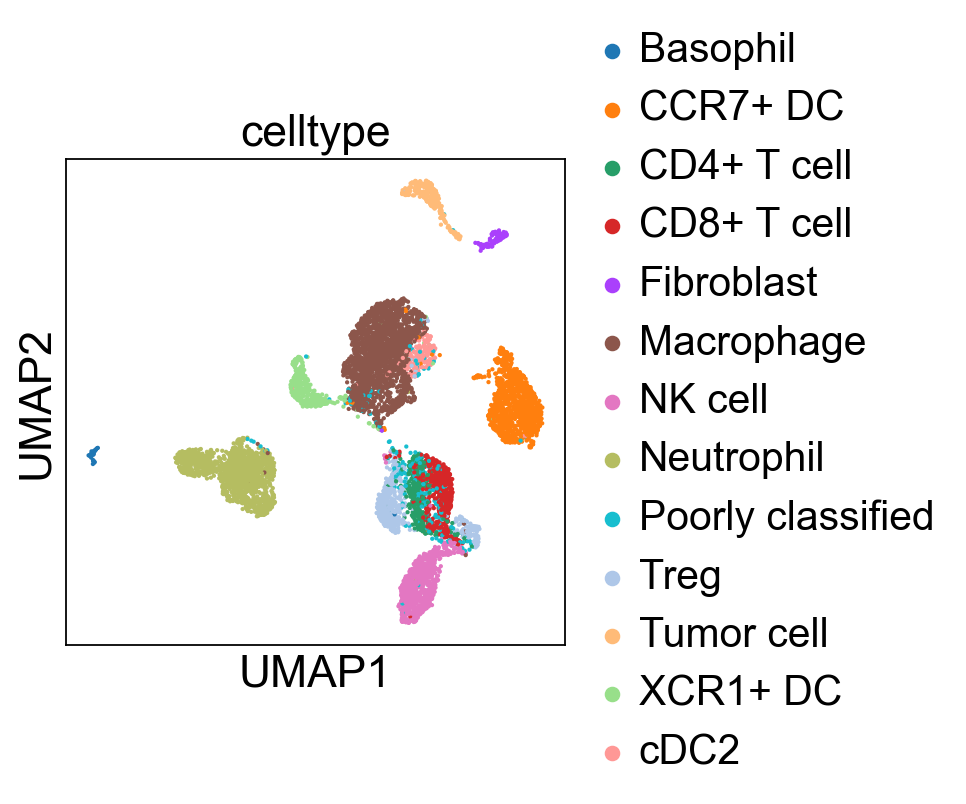

In [45]:
adata_d8 = remove_recompute(adata_d8)
sc.pl.umap(adata_d8, color='celltype')

#adata_d8 = remove_recompute(adata_d8)
#sc.pl.umap(adata_d8, color='celltype')

In [46]:
ctrld8_ind = np.where(adata_d8.obs['sample'] == 'BD2')[0]

In [47]:
d8_pairs = []
for g in np.arange(3, 7):
    next_ind = np.where(adata_d8.obs['sample'] == 'BD{}'.format(g))[0]
    adatas = adata_d8[np.concatenate((ctrld8_ind, next_ind)), :]
    adatas = remove_recompute(adatas)
    d8_pairs.append(adatas.copy())

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_24689/3440526384.py:13: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap']
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_24689/3440526384.py:13: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap']
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_24689/3440526384.py:13: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap']
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_24689/3440526384.py:13: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap']


In [48]:
cpi = d8_pairs[2].concatenate(adata_d8[np.where(adata_d8.obs['sample'] == 'BD4')])

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [51]:
sc.tl.pca(cpi, svd_solver='auto')
sc.pp.neighbors(cpi)
sc.tl.umap(cpi)
sc.tl.diffmap(cpi)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


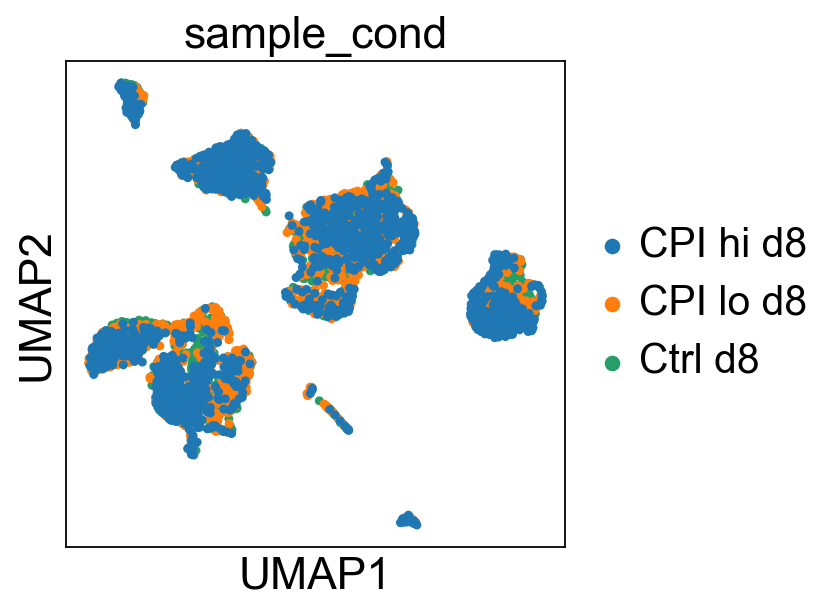

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

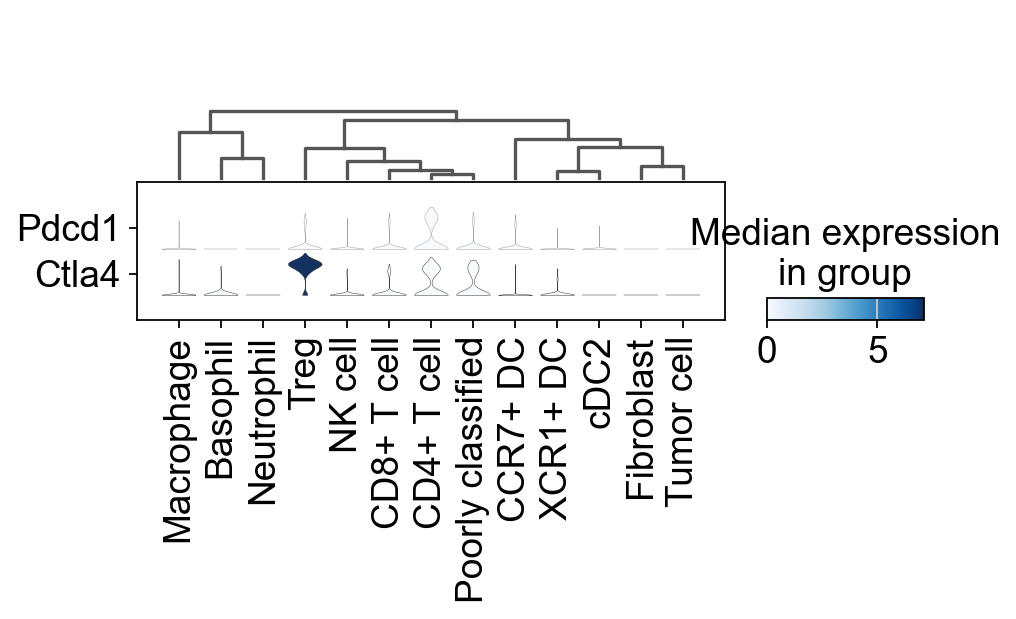

In [52]:
sc.pl.umap(cpi, color='sample_cond', s=65)
sc.pl.stacked_violin(cpi, ['Pdcd1', 'Ctla4'], groupby='celltype', swap_axes=True, dendrogram=True)

In [53]:
cpi.obs['replicate'] = encode_replicates(cpi, None)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_24689/828529630.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs['sample'][z] == 'BD1':


In [54]:
dose_dict = {'Ctrl d8': 0,
             'CPI lo d8': 25,
             'CPI hi d8': 100}
cpi.obs['cond_continuous'] = cpi.obs["sample_cond"].map(dose_dict).astype(int)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_24689/828529630.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action 

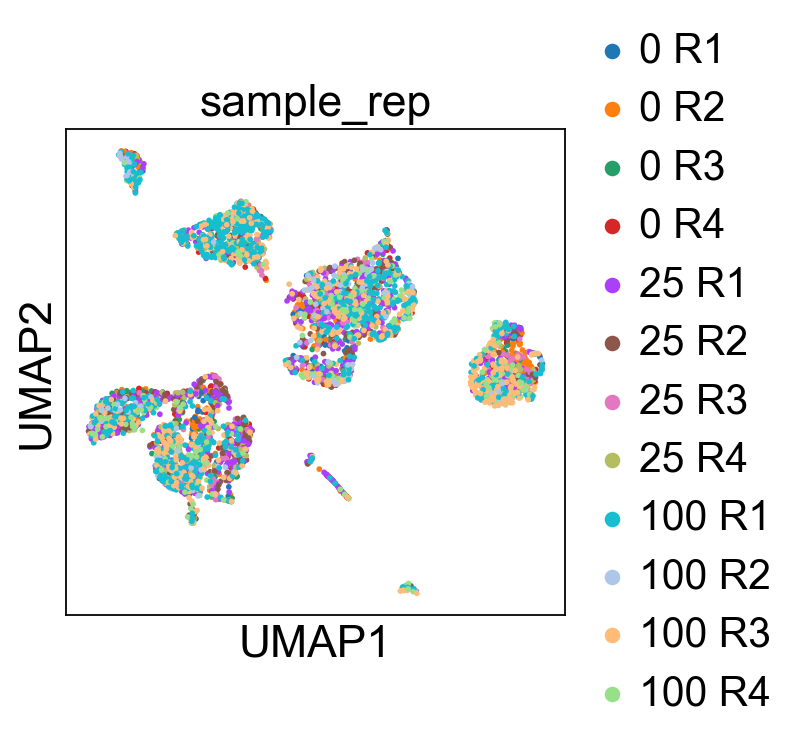

In [55]:
cpi.obs['sample_rep'] = build_samplerep(cpi, 'cond_continuous', 'replicate')
sc.pl.umap(cpi, color='sample_rep')

In [56]:
milo.make_nhoods(cpi)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51.3723068237 40.0406112671 34.9902763367 41.2483787537 29.0946331024
 49.2755012512 28.7683582306 44.8997535706 47.3330879211 50.5420913696
 44.5968284607 43.6493988037 45.3047180176 54.0488700867 47.4824829102
 35.0171813965 51.5712127686 62.4250602722 31.3395271301 35.0872154236
 33.0157775879 64.0110549927 41.9225006104 50.3621368408 51.2773323059
 35.3380584717 27.1046657562 33.3683547974 40.7245368958 52.3809051514
 31.8792762756 47.8571281433 43.320941925  33.9977607727 34.2738571167
 34.5215759277 35.8882369995 35.3107795715 57.1453285217 49.2418861389
 40.5413589478 37.2984352112 48.1304244995 50.7957572937 37.6697006226
 62.138168335  39.9607810974 30.7843055725 50.5223808289 45.2185134888
 47.2552146912 32.2637748718 41.4652442932 52.0231971741 47.8590087891
 40.9709434

In [57]:
cpi.obs['rep_code'] = cpi.obs['sample_rep'].cat.codes
milo.count_nhoods(cpi, sample_col="rep_code")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:306: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:307: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

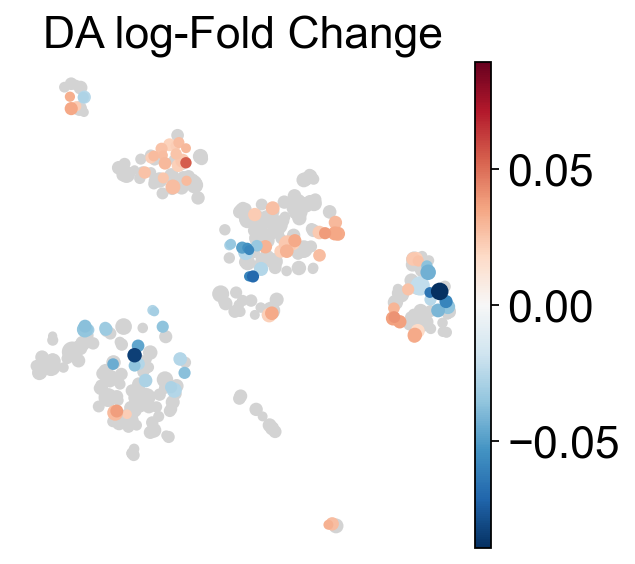

<Figure size 320x320 with 0 Axes>

In [58]:
milo.DA_nhoods(cpi, design="~ cond_continuous")

# Check results
milo_results = cpi.uns["nhood_adata"].obs

# visualize
milopy.utils.build_nhood_graph(cpi)
milopy.plot.plot_nhood_graph(cpi, alpha=0.1, min_size=5)
plt.tight_layout()

In [65]:
adata_d8.obs_keys()

['n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'pct_counts_in_top_50_genes',
 'pct_counts_in_top_100_genes',
 'pct_counts_in_top_200_genes',
 'pct_counts_in_top_500_genes',
 'total_counts_mito',
 'log1p_total_counts_mito',
 'pct_counts_mito',
 'n_counts',
 'n_genes',
 'sample',
 'sample_cond',
 'is_cell',
 'high_confidence',
 'multi_chain',
 'extra_chains',
 'IR_VJ_1_c_call',
 'IR_VJ_2_c_call',
 'IR_VDJ_1_c_call',
 'IR_VDJ_2_c_call',
 'IR_VJ_1_consensus_count',
 'IR_VJ_2_consensus_count',
 'IR_VDJ_1_consensus_count',
 'IR_VDJ_2_consensus_count',
 'IR_VJ_1_d_call',
 'IR_VJ_2_d_call',
 'IR_VDJ_1_d_call',
 'IR_VDJ_2_d_call',
 'IR_VJ_1_duplicate_count',
 'IR_VJ_2_duplicate_count',
 'IR_VDJ_1_duplicate_count',
 'IR_VDJ_2_duplicate_count',
 'IR_VJ_1_j_call',
 'IR_VJ_2_j_call',
 'IR_VDJ_1_j_call',
 'IR_VDJ_2_j_call',
 'IR_VJ_1_junction',
 'IR_VJ_2_junction',
 'IR_VDJ_1_junction',
 'IR_VDJ_2_junction',
 'IR_VJ_1_junction_aa',
 'IR_VJ_2_junction_aa',


Text(0.5, 0, 'celltype fraction')

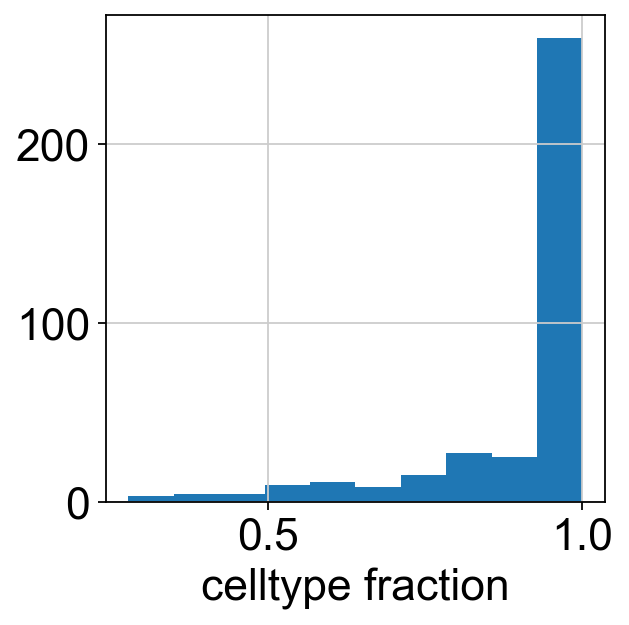

In [66]:
milopy.utils.annotate_nhoods(cpi, anno_col='celltype')
plt.hist(cpi.uns['nhood_adata'].obs["nhood_annotation_frac"])
plt.xlabel("celltype fraction")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


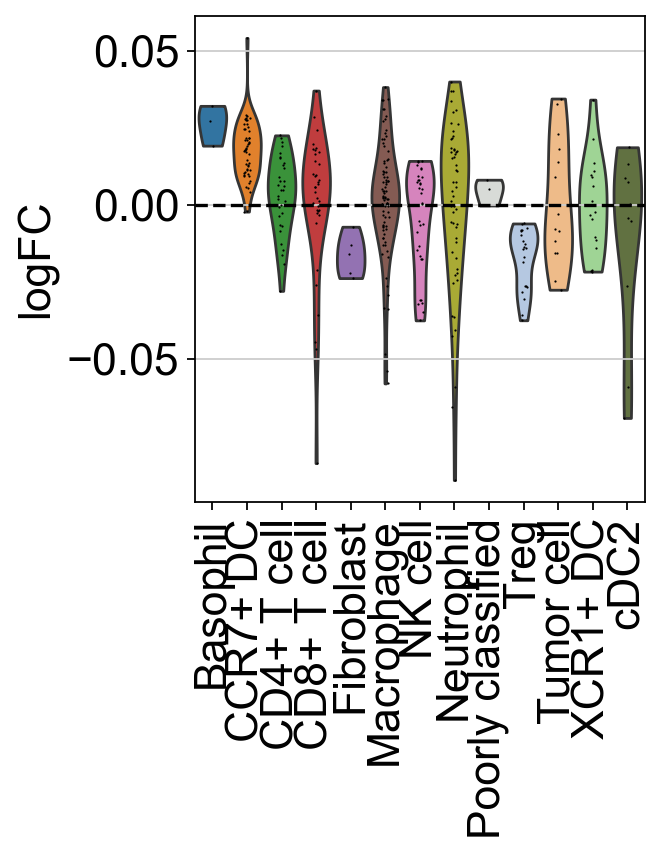

In [67]:
sc.pl.violin(cpi.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False, palette=celltype_dict)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [70]:
from community import community_louvain
import networkx as nx

test_adj2 = group_nhoods(cpi, 3, 0.6)
G_test1 = nx.from_numpy_array(test_adj2)
partition = community_louvain.best_partition(G_test1)
print(np.max(list(partition.values())))

26


/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_24689/828529630.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib

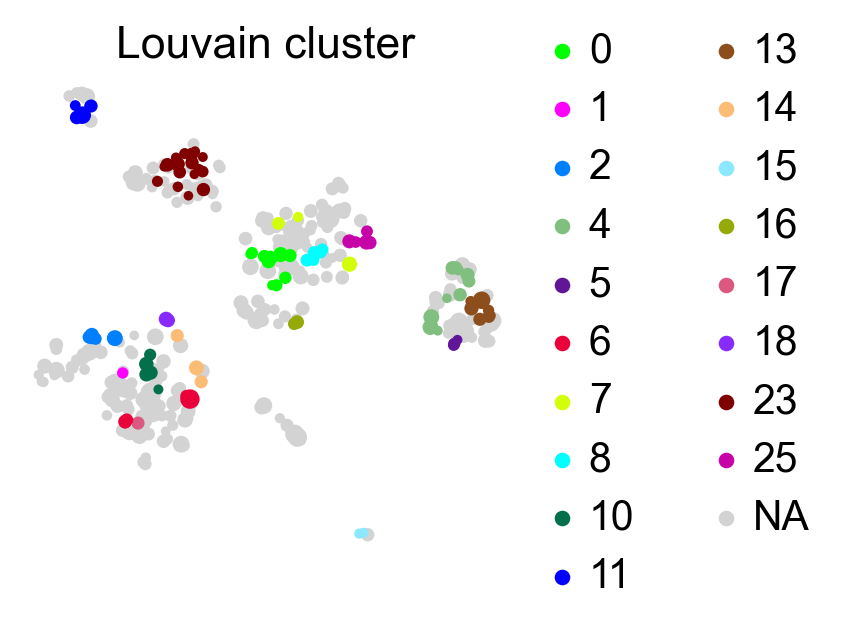

<Figure size 320x320 with 0 Axes>

In [71]:
louvain_lab0, louvain_pal0 = plot_nhood_clusters(cpi, list(partition.values()), 'Louvain cluster', alpha=0.1, min_size=5)
plt.tight_layout()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


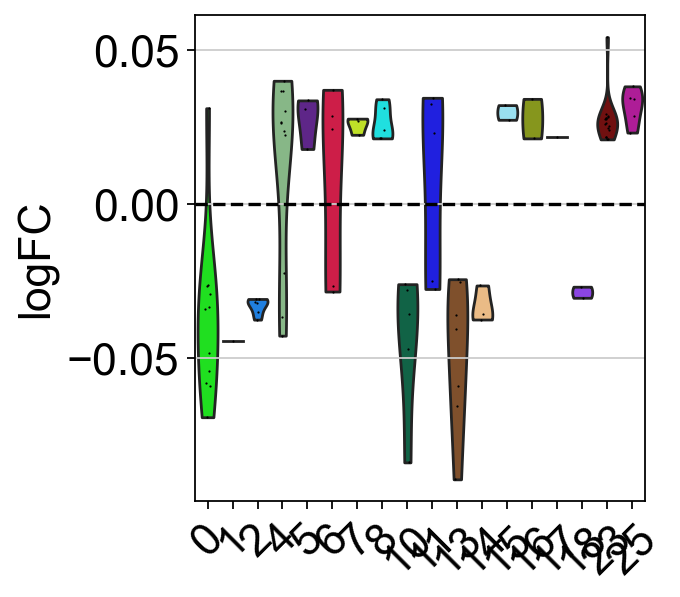

In [72]:
cpi.uns['nhood_adata'].obs['louvain'] = louvain_lab0
louvain_order = np.array([0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 23, 25])
sc.pl.violin(cpi.uns['nhood_adata'], "logFC", groupby="louvain", hue = "louvain", legend = False, show=False, palette=louvain_pal0,
             order=louvain_order, rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [73]:
cpi.obs['sc_louvain'] = get_sc_louvain(cpi)

In [89]:
np.unique(cpi.obs['sample_rep'])[11]

'25 R4'